<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/Week_10/Week_10_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
import time
import re
import nltk
from IPython.display import YouTubeVideo

# nltk.download('stopwords') # uncomment if stopwords is not up-to-date
# nltk.download('punkt')     # uncomment if punkt is not up-to-date
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download("stopwords")
nltk.download('punkt')

# ML import
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA             # PCA
from sklearn.manifold import TSNE                 # t-SNE
from sklearn.manifold import MDS                  # Multidimensional scaling
from sklearn.manifold import Isomap               # Isomap
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# import mnist
from keras.datasets import mnist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Dimensionality Reduction

<img src='https://media.tenor.com/fh89_ZNYrnwAAAAC/flat-earth-dinosaurs.gif' width="500">

## Content

The goal of this walkthrough is to provide you with insights on Dimensionality Reduction. After presenting the main concepts, you will be introduced to the techniques to implement dimensionality reduction techniques, e.g., PCA, t-SNE, multidimensional scaling, Isomap. Finally, we'll explore a few applications to demonstrate the usefulness of dimensionality reduction for data visualization and classification tasks.  

This notebook is organized as follows:
- [Background](#Background)
    - [Principal Component Analysis](#Principal-Component-Analysis)
        - [Finding principal components](#Finding-principal-components)
        - [How many dimensions?](#How-many-dimensions?)
        - [Practical issues of PCA](#Practical-issues-of-PCA)
        - [Further reading](#Further-reading)
    - [t-SNE](#t-SNE)
        - [How does t-SNE work?](#How-does-t-SNE-work?)
        - [Practical issues of t-SNE](#Practical-issues-of-t-SNE)
        - [References and further reading](#References-and-further-reading)
- [Implementation](#Implementation)
    - [PCA](#PCA)
    - [t-SNE and other Manifold Learning techniques](#t-SNE-and-other-Manifold-Learning-techniques)
    - [Your turn!](#Your-turn!)
- [Applications](#Applications)
    - [PCA for visualization: Palmer penguins](#PCA-for-visualization:-Palmer-penguins)
    - [SMS Classification: with vs. without PCA](#SMS-Classification:-with-vs.-without-PCA)
        - [Discover dataset](#Discover-dataset)
        - [Data preparation and cleaning](#Data-preparation-and-cleaning)
        - [Dimensionality reduction and Classification](#Dimensionality-reduction-and-Classification)

## Background

[Dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data.

Dimensionality reduction is useful to:
- Visualize data
- Deal with the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)
- Removing noise, leading to better prediction and classification accuracy
- Reduce time complexity (faster to train algorithms with less features)
- Compress data (less space needed)

We generally distinguish between two sets of techniques:
- [Feature selection](https://en.wikipedia.org/wiki/Feature_selection), which consists in selecting a subset of relevant features, using, for instance:
    - domain knowledge ,
    - information gain, e.g., in decision trees at each node we select the feature that maximizes the information gained,
    - properties of your features, e.g., correlation, with the assumption that the prediction/classification performance is improved when features are highly correlated with the outcome, yet uncorrelated to each others,
    - regularization techniques (LASSO, Ridge, Elastic Net)
- [Feature extraction](https://en.wikipedia.org/wiki/Feature_extraction), which consists in transforming our original features into new features that should be informative and non-redundant.

This notebook focuses on feature extraction. We detail below a few techniques, namely Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE).

### Principal Component Analysis


If you want to watch a small introduction video about PCA:





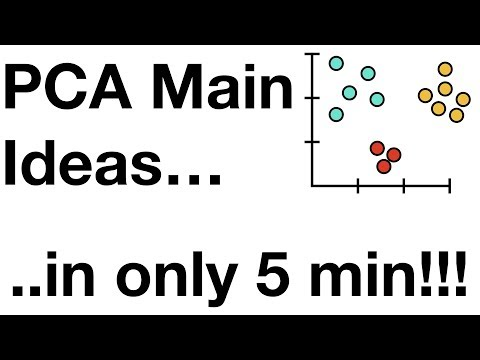

In [2]:
YouTubeVideo('HMOI_lkzW08')

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) performs a linear combination of our original features into new and linearly-uncorrelated features, called **principal components**. The principal components are constructed such that:
- the first principal component is the direction of greatest variability in the data, i.e., it has the largest possible [variance](https://en.wikipedia.org/wiki/Variance);
- each succeeding component in turn has the highest variance possible, under the constraint that it is [orthogonal](https://en.wikipedia.org/wiki/Orthogonal) to the preceding components.

The orthogonality constraint allows to build linearly-uncorrelated features. But why are we interested in the direction of greatest variability? Well, consider the figure below, the direction of the first principal component (V1) has the largest spread (variance). It is also the direction that distorts the least our observations when performing a projection. In other words, the direction of the largest variance is also the direction that minimizes the distances between the original points and their projections. In this sense, it is the most informative direction.  

<img src='http://lazyprogrammer.me/wp-content/uploads/2015/11/PCA.jpg' width="400">

Source: [Tutorial: Principal Components Analysis (PCA)](https://lazyprogrammer.me/tutorial-principal-components-analysis-pca/), Lazy Programmer


#### Finding principal components

How do we find the direction of largest variance? Let's formalize our problem!

Say we have a matrix of $p$ features $\boldsymbol{X}=[\boldsymbol{x_1}$, ... , $\boldsymbol{x_p}]$, each feature having $n$ observations $\boldsymbol{x_j}=(x_{1j}, x_{2j}, ..., x_{nj})$. We assume that the mean of each feature is zero; otherwise the first step is to center the data at zero by subtracting the mean of each feature.

Each principal component is a linear combination of our features, i.e., it can be represented by a vector of dimension $p$: $\boldsymbol{\phi_k} = (\phi_{k,1}, \phi_{k,2}, ..., \phi_{k,p})$, where $\phi_{k,j}$ are the weights associated with each feature. We impose that $\boldsymbol{\phi_k}$ is a unit vector, i.e., $|| \boldsymbol{\phi_k} ||=\sum_j (\phi_{k,j})^2=1$. Indeed, there exists an infinity of vectors that have the same direction, so we need to select one, and the unit vector leads to some interesting properties that we will discover below.

For each observation $i = 1,...,n$ and each principal component $k$, we define a principal component *score* $z_{k,i}$:

$$ z_{k,i} = \phi_{k,1} x_{i1} + \phi_{k,2} x_{i2} + ... + \phi_{k,p} x_{ip} = \sum_{j=1}^p \phi_{k,j} x_{ij} $$

Note that $z_{k,i}$ is the scalar [projection](https://en.wikipedia.org/wiki/Vector_projection) of observation $i$ on the principal component $\boldsymbol{\phi_k}$.  

The first principal component is the direction of the largest variance. More explicitly, our problem consists in finding the weights $(\phi_{1,1}, \phi_{1,2}, ..., \phi_{1,p})$ that maximizes the variance of the projections $\boldsymbol{z_1}=(z_{1,1}, z_{1,2},..., z_{1,n})$, such that $\boldsymbol{\phi_1}$ is a unit vector. Note that since the mean of each feature is zero, the mean of $\boldsymbol{z_1}$ is also zero. Hence, we need to solve the following problem:

$$\boldsymbol{\phi_1} = \arg \max_{|| \boldsymbol{\phi_1} || =1} \left\{  \frac{1}{n} \sum_{i=1}^n (z_{1,i})^2 \right \} =  \arg \max_{|| \boldsymbol{\phi_1} || =1} \left\{  \frac{1}{n} \sum_{i=1}^n \left(\sum_{j=1}^p \phi_{1,j} x_{ij} \right)^2 \right \} $$

Once $\boldsymbol{\phi_1}$ is found, we can compute for each observation $i$ the principal component score $z_{1,i}$, and $\boldsymbol{z_1}$ is our new feature.

We proceed similarly to find the other components: the $k^{th}$ component can then be found by subtracting the first $k$ − 1 principal components from $\mathbf{X}$ and finding the weights that maximize the variance of the new projections.

However, in practice, the principal components are computed differently. Let's take a step back and reconsider our optimization problem above. When solving it, by adding a Lagrangian multiplier $\lambda_1$ and taking the derivatives with respect to each weight $\phi_{1,j}$, we obtain, with some reshuffling:

$$\boldsymbol{\Sigma} \boldsymbol{\phi_1}  = \lambda_1 \boldsymbol{\phi_1} $$

where $\boldsymbol{\Sigma}$ is the covariance matrix of our features. We can get similar equations for all principal components $\boldsymbol{\Sigma} \boldsymbol{\phi_k}  = \lambda_k \boldsymbol{\phi_k}$.

If you are familiar with linear algebra, you will have recognized this equation: it means that the ***principal components are the [eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of the covariance matrix of our features***!

Not only that, we can show that, because $\boldsymbol{\phi_k}$ are unit vectors, the ***eigenvalues*** ($\lambda_k$) are equal to the ***variance*** of the projections. Hence, the first principal component is the eigenvector of the covariance matrix with the largest eigenvalues, and so on.

Consequently, we can compute the principal components thanks to [eigenvalue decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of the covariance matrix or the more general [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)(SVD).

#### How many dimensions?

We want to select $m$ principal components such that we (vastly) reduce our feature space ($m<<p$) while explaining the most variance ("information"). There are several techniques, such as:
- using a [scree plot](https://en.wikipedia.org/wiki/Scree_plot): rank principal components by the amount of variance they capture in the original dataset, i.e., from largest to smallest eigenvalue, and look for the elbow of the curve
- picking the first $m$ eigenvectors that explain a certain percentage of the total variance, e..g.90% or 95%: $\frac{\sum_{k=1}^m \lambda_k}{\sum_{k=1}^p \lambda_k} \geq 0.9$  

#### Practical issues of PCA

Even though PCA is a very nice technique building on the geometry of our data, there are a few practical considerations to keep in mind before using it:
- since the covariance is extremely sensitive to large values, it is best to normalize your features to zero mean and unit variance before performing PCA,
- PCA is a linear transformation, i.e., it assumes that the direction of greater variability is linear, which is not always the case.

#### Further reading

To further deepen your understanding of PCA, you can refer to the following materials:
- [Principal Component Analysis](https://www.youtube.com/watch?v=IbE0tbjy6JQ&list=PLBv09BD7ez_5_yapAg86Od6JeeypkS4YM) lecture by Victor Lavrenko (playlist of short videos), which includes the proofs of why the eigenvectors are the principal components and the eigenvalues the variance of the projections
- [Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/), blog post by Alex Williams
- [Eigenvectors and eigenvalues](https://www.youtube.com/watch?v=PFDu9oVAE-g), video by 3Blue1Brown, for a visual understanding of eigenvectors and eigenvalues
- [A geometric interpretation of the covariance matrix](https://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/), blog post by Vincent Spruyt, to explore the geometric properties of the covariance matrix

### t-SNE

Unlike PCA, [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE) is a [nonlinear dimensionality reduction](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) technique. The method attempts to learn a low-dimensional representation of the data that preserves the local structure of the data. It attempts to preserve pairwise distance and "cluster" information.

You can watch here a small introduction video about t-SNE:

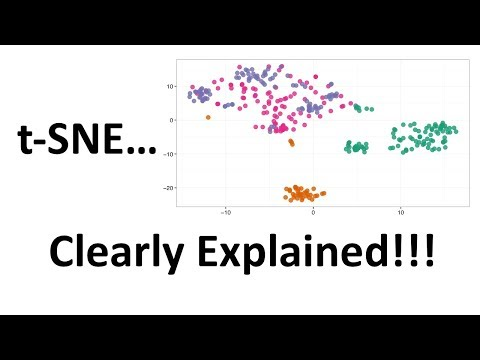

In [3]:
YouTubeVideo('NEaUSP4YerM')

#### How does t-SNE work?

t-SNE maps the data points from our initial high-dimensional space to a low-dimensional space in such a way that similar data points are close to each other in the low-dimensional space. The method involves two main steps:
1. we compute the probability of similarity between each pair of data points in the high-dimensional space
2. we compute the probability of similarity between each pair of data points in the low-dimensional space
The objective is to minimize the difference between the two similarity probabilities to find the best mapping between the high-dimensional data and the low-dimensional space.

Let's formalize this.We have a matrix of $p$ features $\boldsymbol{X}$, each feature having $n$ observations. We call $\boldsymbol{x_{(i)}}=(X_{i1}, X_{i2}, ..., X_{ip})$ the $i^{th}$ observation. Note that in the previous section $\boldsymbol{x_{j}}$ was referring to feature $j$, i.e., a column of the matrix feature, while $\boldsymbol{x_{(i)}}$ refers to observation $i$, i.e., a row of the matrix feature.

The first step is to compute the similarity between each pair of data points. This similarity of datapoint $\boldsymbol{x_{(a)}}$ to datapoint $\boldsymbol{x_{(b)}}$ is defined to be the conditional probability $p_{b|a}$ that $\boldsymbol{x_{(a)}}$ would pick $\boldsymbol{x_{(b)}}$ as its neighbor, if the neighbors were picked in proportion to their probability density under a Gaussian centered at $\boldsymbol{x_{(a)}}$:

$$p_{b|a} = \frac{\exp(- ||\boldsymbol{x_{(a)}} - \boldsymbol{x_{(b)}}||^2 / 2 \sigma_a^2)}{\sum_{i \neq a} \exp(- ||\boldsymbol{x_{(a)}} - \boldsymbol{x_{(i)}}||^2 / 2 \sigma_a^2)}$$

We set $p_{a|a}=0$. The variance $\sigma_a^2$ is set such that the entropy of the conditional distribution equals a predefined entropy, specified by a parameter called *perplexity*: $Perp = 2^{-\sum_i p_{i|a} \log_2 p_{i|a}}$. The perplexity can be interpreted as the number of neighbors for our central point. As a result, the variance is adjusted to the density of the data: smaller values of $\sigma_a^2$ are used in denser part of the data space.

See the illustration in the figure below, at the top is our initial space and at the bottom the similarities to the red observation.

<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/0*Afr8xsKrl6dwZ10Q.png' width="500">

Source: [t-SNE clearly explained](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a), by Kermal Erdem

Note that since the variances $\sigma_a^2$ and $\sigma_b^2$ differ, so do $p_{b|a}$ and $p_{a|b}$. We thus define:
$$p_{ab} = \frac{p_{a|b}+p_{b|a}}{2n} $$

Ok, we have defined similarities between two observations in our original data space. Our objective is to map our initial p-dimensional data points $\boldsymbol{x_{(i)}}$ to lower-dimensional points $\boldsymbol{y_{(i)}}$, such that the similarities in the high-dimensional space match the ones in the low- dimensional space. Thus, next step is to define similarities, $q_{ab}$, in a low-dimensional space. We use a [Student t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) (hence the name of the algorithm):

$$q_{ab}=\frac{(1+||\boldsymbol{y_{(a)}} - \boldsymbol{y_{(b)}}||^2)^{-1}}{\sum_k \sum_{k \neq l}(1+||\boldsymbol{y_{(k)}} - \boldsymbol{y_{(l)}}||^2)^{-1}}$$

Laurens Van der Maaten and Geoffrey Hinton, who introduced this distribution, discuss the rationale behind this assumption in their paper [Visualizing data using t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).

Last step, we find the new data points $\boldsymbol{y_{(i)}}$ by minimizing the distance between the two similarity distributions. We use the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence):

$$\sum_{a \neq b} p_{ab} \log \frac{p_{ab}}{q_{ab}}$$

#### Practical issues of t-SNE

t-SNE is effective in preserving the local structure of the data points, making it ideal for visualizing complex and non-linear data. As drawbacks, the method is:
- computationally expensive
- sensitive to initial conditions, e.g., perplexity. You can read [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/), by Martin Wattenberg, Fernanda Viégas and Ian Johnson, for a nice discussion and good practices
- not guaranteed to preserve the global structure of data. For instance, t-SNE is not recommended for clustering analysis or outlier detection since it does not necessarily preserve densities or distances

#### References and further reading

- Van der Maaten, L., & Hinton, G. (2008). [Visualizing data using t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). *Journal of machine learning research*, 9(11).
- [t-SNE clearly explained](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a), by Kemal Erdem
- [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/), by Martin Wattenberg, Fernanda Viégas and Ian Johnson

## Implementation

We present in this section how to implement dimensionality reduction techniques using some synthetic data to better understand the algorithms.

### PCA

We use the `PCA` module of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA))

```python
from sklearn.decomposition import PCA
```

Ok, let's try with some synthetic data, in two dimensions to visualize the results.

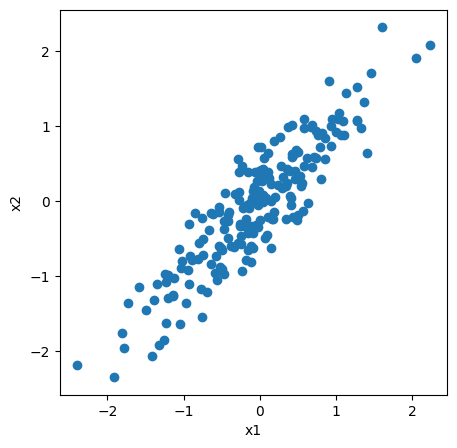

In [4]:
## Generate 2D points
rng = np.random.RandomState(7)
X_2D = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

## Plot
plt.figure(figsize=(5,5))
plt.scatter(X_2D[:, 0], X_2D[:, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

We use `PCA()` specifying the number of components `n_components`. Here, we are in 2 dimensions, there are thus 2 principal components.

In [5]:
## PCA
# Create instance of PCA with the desired number of components
pca_2D = PCA(n_components=2)
# Fit: find principal components
pca_2D.fit(X_2D)

PCA(n_components=2)

With `.fit()` we have learned our principal components, i.e., the eigenvectors of the covariance matrix, and the explained variance, i.e., the eigenvalues:

In [6]:
# Print components = eigenvectors
print('The eigenvectors are:')
print(pca_2D.components_)

# Print explained variance = eigenvalues
print('The eigenvalues are:', pca_2D.explained_variance_)

The eigenvectors are:
[[-0.67415701 -0.73858806]
 [ 0.73858806 -0.67415701]]
The eigenvalues are: [1.21551024 0.06392182]


Let's visualize this. We use the components to define the direction of the vector, and the explained variance to define the squared-length of the vector:

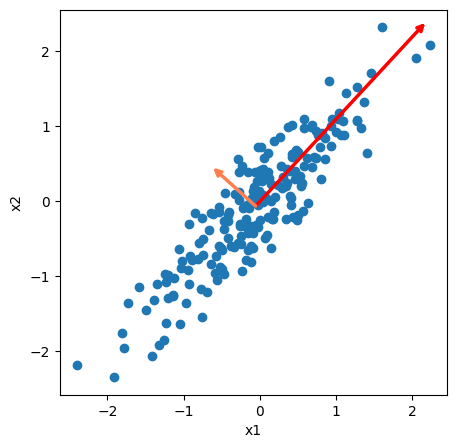

In [7]:
# Function to draw vectors
def draw_vector(v0, v1, color, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2.5,
                    color = color,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

## Plot
colors_vec = ['red','coral']
plt.figure(figsize=(5,5))
plt.scatter(X_2D[:, 0], X_2D[:, 1])
for length, vector, col in zip(pca_2D.explained_variance_, pca_2D.components_, colors_vec):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca_2D.mean_, pca_2D.mean_ - v, col)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

The red vector is the first principal component and the orange one the second principal component. As seen in the figure, they are orthogonal and the first principal component is the direction of largest variance.

Let's now transform our points to reduce the dimension. In other words, we will project our points on the first principal components:

In [8]:
## PCA
# Create instance of PCA with the desired number of components
pca_1D = PCA(n_components=1)
# Fit: find principal components
pca_1D.fit(X_2D)
# Transform our points: projection
X_2D_pca = pca_1D.transform(X_2D)
# Note: instead of .fit() and .transform(), we could directly use .fit_transform()

print("Original shape:   ", X_2D.shape)
print("Transformed shape:", X_2D_pca.shape)

Original shape:    (200, 2)
Transformed shape: (200, 1)


We transformed our 2D points into 1D point. To transform the data back to its original dimension, we can use the method `.inverse_transform()`:

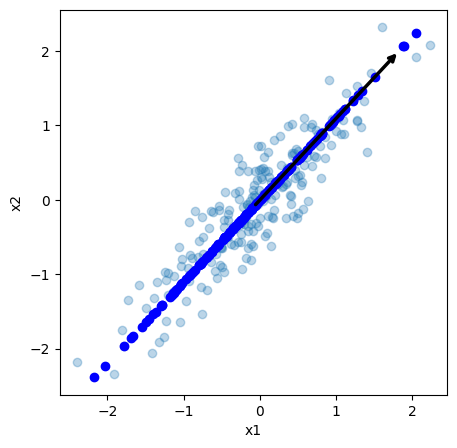

In [9]:
# Transform projections to original dimension
X_2D_new = pca_1D.inverse_transform(X_2D_pca)

# Plot
plt.figure(figsize=(5,5))
plt.scatter(X_2D[:, 0], X_2D[:, 1], alpha = 0.3)
plt.scatter(X_2D_new[:, 0], X_2D_new[:, 1], color = 'blue')
v1 = pca_1D.components_[0] * 2.5 * np.sqrt(pca_1D.explained_variance_)
draw_vector(pca_1D.mean_, pca_1D.mean_ -  v1, 'black')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

As displayed in the figure, the 2D data points were projected on the first principal components. In other words, with PCA, the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out is roughly a measure of how much "information" is discarded in this reduction of dimensionality. The reduced-dimension dataset should preserve the overall relationship between the data points.

One of the weakness of PCA is that it tends to be highly affected by outliers in the data. Many robust variants of PCA have been developed to overcome this limitation, with the idea to iteratively discard data points that are poorly described by the initial components. For instance, `SparsePCA` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)) introduces a regularization term that serves to enforce sparsity of the components.

Discover other options in sklearn [user guide](https://scikit-learn.org/stable/modules/decomposition.html)!

### t-SNE and other Manifold Learning techniques

We have previously discussed that PCA assumes that the direction of greater variability is linear. What if it is not the case? For instance, consider the famous [Swiss roll](https://en.wikipedia.org/wiki/Swiss_roll) (which is not from Switzerland...):

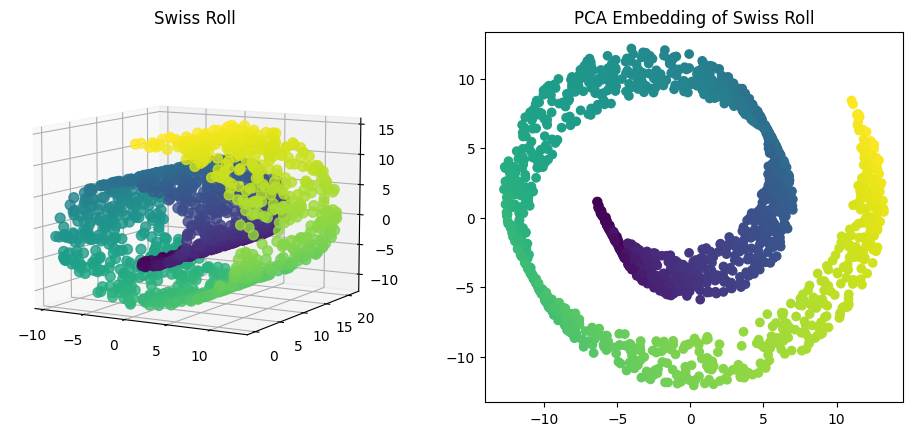

In [10]:
## Generate Swiss roll
sr_points, sr_color = datasets.make_swiss_roll(n_samples=1500, random_state=0)

## PCA
sr_pca = PCA(n_components=2).fit_transform(sr_points)

## Plot
fig = plt.figure(figsize=(10, 5))
# Swiss Roll
ax = fig.add_subplot(1,2,1, projection="3d")
ax.scatter(sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8)
ax.set_title("Swiss Roll")
ax.view_init(azim=-60, elev=9)
# Swiss Roll projected with PCA
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(sr_pca[:, 0], sr_pca[:, 1], c=sr_color)
ax2.set_title("PCA Embedding of Swiss Roll")
fig.tight_layout(pad=3.0)
plt.show()

Notice what happened? The PCA "cut" the Swiss roll, but by doing so we lost some information.

Let's try with manifold learning, i.e., nonlinear dimensionality reduction techniques:
- t-distributed Stochastic Neighbor Embedding (t-SNE), using the `TSNE` module of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)).
    - as parameters, we specify the number of components (dimensions) `n_components` and the `perplexity`, which can be interpreted as the number of nearest neighbors.
- [Multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) (MDS) , using the `MDS` module ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html))
    - MDS seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space
    - as parameters, we specify the number of components (dimensions) `n_components`
- [Isomap](https://en.wikipedia.org/wiki/Isomap), using the `Isomap` module ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html))
    - Isomap seeks a lower-dimensional embedding which maintains [geodesic](https://en.wikipedia.org/wiki/Geodesic) distances between all points. It can be viewed as an extension of MDS, using geodesic distances instead of Euclidean distances. In short, the idea is to:
        1) determine the k nearest neighbors of each point
        2) construct a neighborhood graph by connecting each point to its nearest neighbors
        3) compute the geodesic distances between points, defined as the shortest path
        4) find the lower-dimensional embedding such that the (Euclidean) distances in the low-dimensional space are close to the geodesic distances
    - as parameters, we specify the number of components (dimensions) `n_components` and the number of neighbors to each point `n_neighbors`

Do not hesitate to check the [user guide](https://scikit-learn.org/stable/modules/manifold.html) for more details on each approach!

In [11]:
## t-SNE
# Create instance of TSNE
tsne_sr = TSNE(n_components=2, perplexity=40, random_state=0)
# Fit and project points
start = time.time()
sr_tsne = tsne_sr.fit_transform(sr_points)
end = time.time()
print('Time to run t-SNE algorithm', end-start)

## MDS
# Create instance of MDS
mds_sr = MDS(n_components=2, max_iter=50, random_state=0, normalized_stress = 'auto')
# Fit and project points
start = time.time()
sr_mds = mds_sr.fit_transform(sr_points)
end = time.time()
print('Time to run MDS algorithm', end-start)

## Isomap
# Create instance of Isomap
isomap_sr = Isomap(n_components=2, n_neighbors=10)
# Fit and project points
start = time.time()
sr_isomap = isomap_sr.fit_transform(sr_points)
end = time.time()
print('Time to run Isomap algorithm', end-start)

Time to run t-SNE algorithm 40.09262704849243
Time to run MDS algorithm 33.347307205200195
Time to run Isomap algorithm 2.902709722518921


Isomap was much faster than t-SNE and MDS. But what about the quality of the projections? Let's visualize the results:

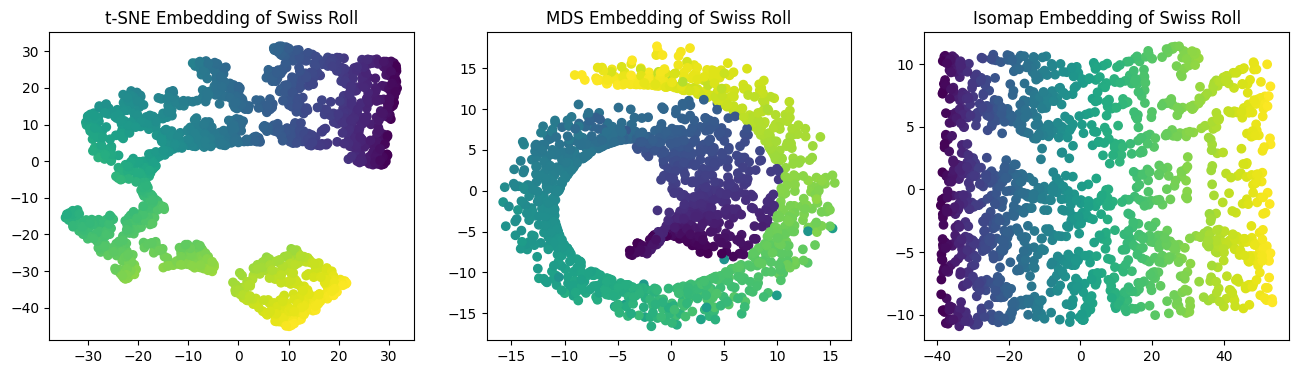

In [12]:
## Plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
axs[0].scatter(sr_tsne[:, 0], sr_tsne[:, 1], c=sr_color)
axs[0].set_title("t-SNE Embedding of Swiss Roll")
axs[1].scatter(sr_mds[:, 0], sr_mds[:, 1], c=sr_color)
axs[1].set_title("MDS Embedding of Swiss Roll")
axs[2].scatter(sr_isomap[:, 0], sr_isomap[:, 1], c=sr_color)
axs[2].set_title("Isomap Embedding of Swiss Roll")
plt.show()

t-SNE seems to preserve the general structure of the data, but, poorly represents the continuous nature of the Swiss roll. MDS improves a bit over PCA (more information is retained), but does not capture well the pattern of our manifold. On the other hand, Isomap perfectly unroll the Swiss roll!

### Your turn!

Consider the following "noisy plane":

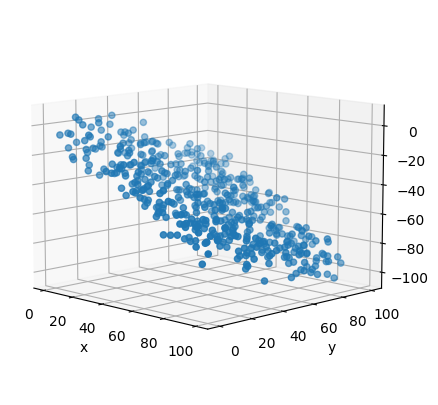

In [26]:
## Plane function -> ax + by + cz = d + e
rng = np.random.RandomState(7)

def noisy_plane(a, b, c, d, noise, n):
    """Function returns n points belonging to a plane in 3D, with some added noise.
       Equation of plane -> ax + by + cz = d
    """
    # Generate n points
    x = 100*rng.rand(n)
    y = 100*rng.rand(n)
    # Noise
    e = rng.normal(0, noise, n)
    # Calculate the third coordinate of the plane
    z = (d - a*x - b*y + e)/c
    # Make and return DataFrame
    df = pd.DataFrame(np.array([x,y,z])).transpose()
    df.columns = ['x', 'y', 'z']
    return df

# Number of points
n_samples = 500

# Plane with noise of 50
df = noisy_plane(-2, -1, -3, 0, 25, n_samples)

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(df['x'], df['y'], df['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=-45, elev=10)

plt.show()

- Implement PCA with 2 components. Show (print) the components and the explained variance. Plot the projections of the points in a 3D scatter plot.

In [96]:
# Create instance of PCA with the desired number of components
pca_lab = PCA(n_components=2)
# Fit: find principal components
pca_lab.fit(df)

# Print components = eigenvectors
print('The eigenvectors are:')
print(pca_lab.components_)
# Print explained variance = eigenvalues
print('The eigenvalues are:', pca_lab.explained_variance_)

The eigenvectors are:
[[-0.73852684 -0.29099231  0.60819535]
 [ 0.40178927 -0.91434303  0.05042026]]
The eigenvalues are: [1285.70793243  847.10454669]


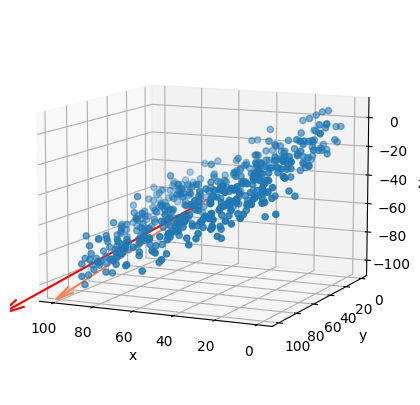

In [98]:
# Function to draw vectors
def draw_vector(v0, v1, color, ax=None):
    ax.quiver(v0[0], v0[1], v0[2], v1[0], v1[1], v1[2], color=color, arrow_length_ratio=0.1)

colors_vec = ['red','coral']

#plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(df['x'], df['y'], df['z'])
for length, vector, col in zip(pca_lab.explained_variance_, pca_lab.components_, colors_vec):
    v = vector * np.sqrt(length)
    draw_vector(pca_lab.mean_, pca_lab.mean_ - v, col, ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=115, elev=10)
plt.show()

In [113]:
# Transform our points: projection
df_pca = pca_lab.transform(df)
df_new = pca_lab.inverse_transform(df_pca)

# Note: instead of .fit() and .transform(), we could directly use .fit_transform()

print("Original shape:   ", df.shape)
print("Transformed shape:", df_pca.shape)

Original shape:    (500, 3)
Transformed shape: (500, 2)


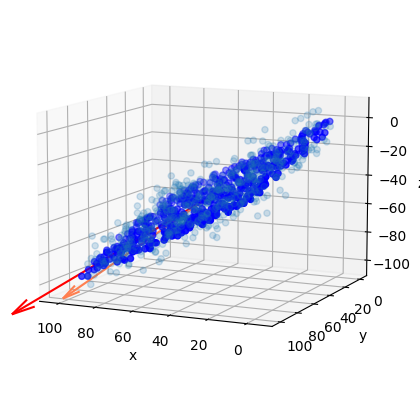

In [122]:
# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(df['x'], df['y'], df['z'], alpha = 0.2)
ax.scatter(df_new[:,0], df_new[:,1], df_new[:,2], color='blue')
for length, vector, col in zip(pca_lab.explained_variance_, pca_lab.components_, colors_vec):
    v = vector * np.sqrt(length)
    draw_vector(pca_lab.mean_, pca_lab.mean_ - v, col, ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=115, elev=10)
plt.show()

- Implement manifold learning techniques (e.g., t-SNE, Isomap, MDS) and compare the results to what you obtained with PCA.

In [131]:
# YOUR CODE HERE
## t-SNE
# Create instance of TSNE
tsne_lab = TSNE(n_components=2, perplexity=40, random_state=0)
# Fit and project points
start = time.time()
lab_tsne = tsne_lab.fit_transform(df)
end = time.time()
print('Time to run t-SNE algorithm', end-start)

## MDS
# Create instance of MDS
mds_lab = MDS(n_components=2, max_iter=50, random_state=0, normalized_stress = 'auto')
# Fit and project points
start = time.time()
lab_mds = mds_lab.fit_transform(df)
end = time.time()
print('Time to run MDS algorithm', end-start)

## Isomap
# Create instance of Isomap
isomap_lab = Isomap(n_components=2, n_neighbors=10)
# Fit and project points
start = time.time()
lab_isomap = isomap_lab.fit_transform(df)
end = time.time()
print('Time to run Isomap algorithm', end-start)

Time to run t-SNE algorithm 6.01749324798584
Time to run MDS algorithm 1.0491645336151123
Time to run Isomap algorithm 0.1630103588104248


Consider the following 3-dimensional S-curve

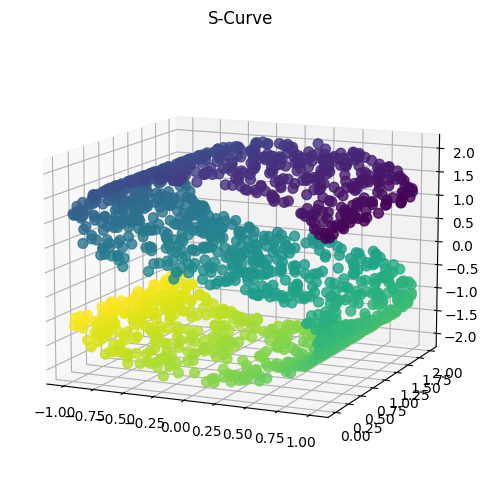

In [137]:
S_points, S_color = datasets.make_s_curve(1500, random_state=0)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    S_points[:, 0], S_points[:, 1], S_points[:, 2], c=S_color, s=50, alpha=0.8
)
ax.set_title("S-Curve")
ax.view_init(azim=-66, elev=12)
plt.show()

- Implement various manifold learning techniques, playing with the parameters of the algorithms

In [156]:
## t-SNE
# Create instance of TSNE
tsne_lab_1 = TSNE(n_components=2, perplexity=10, random_state=0)
tsne_lab_2 = TSNE(n_components=2, perplexity=40, random_state=0)
tsne_lab_3 = TSNE(n_components=2, perplexity=50, random_state=0)
# Fit and project points
lab_tsne_1 = tsne_lab_1.fit_transform(S_points)
lab_tsne_2 = tsne_lab_2.fit_transform(S_points)
lab_tsne_3 = tsne_lab_3.fit_transform(S_points)

In [154]:
## MDS
# Create instance of MDS
mds_lab_1 = MDS(n_components=2, max_iter=50, random_state=0, normalized_stress = 'auto')
mds_lab_2 = MDS(n_components=2, max_iter=300, random_state=0, normalized_stress = 'auto')
mds_lab_3 = MDS(n_components=2, max_iter=30, random_state=0, normalized_stress = False)
# Fit and project points
lab_mds_1 = mds_lab_1.fit_transform(S_points)
lab_mds_2 = mds_lab_2.fit_transform(S_points)
lab_mds_3 = mds_lab_3.fit_transform(S_points)


In [179]:
## Isomap
# Create instance of Isomap
isomap_lab_1 = Isomap(n_components=2, n_neighbors=100, neighbors_algorithm='brute', path_method='auto', p=1)
isomap_lab_2 = Isomap(n_components=2, n_neighbors=100, neighbors_algorithm='kd_tree', path_method='D', p=2)
isomap_lab_3 = Isomap(n_components=2, n_neighbors=100, neighbors_algorithm='ball_tree', path_method='FW', p=2)
# Fit and project points
lab_isomap_1 = isomap_lab_1.fit_transform(S_points)
lab_isomap_2 = isomap_lab_2.fit_transform(S_points)
lab_isomap_3 = isomap_lab_3.fit_transform(S_points)

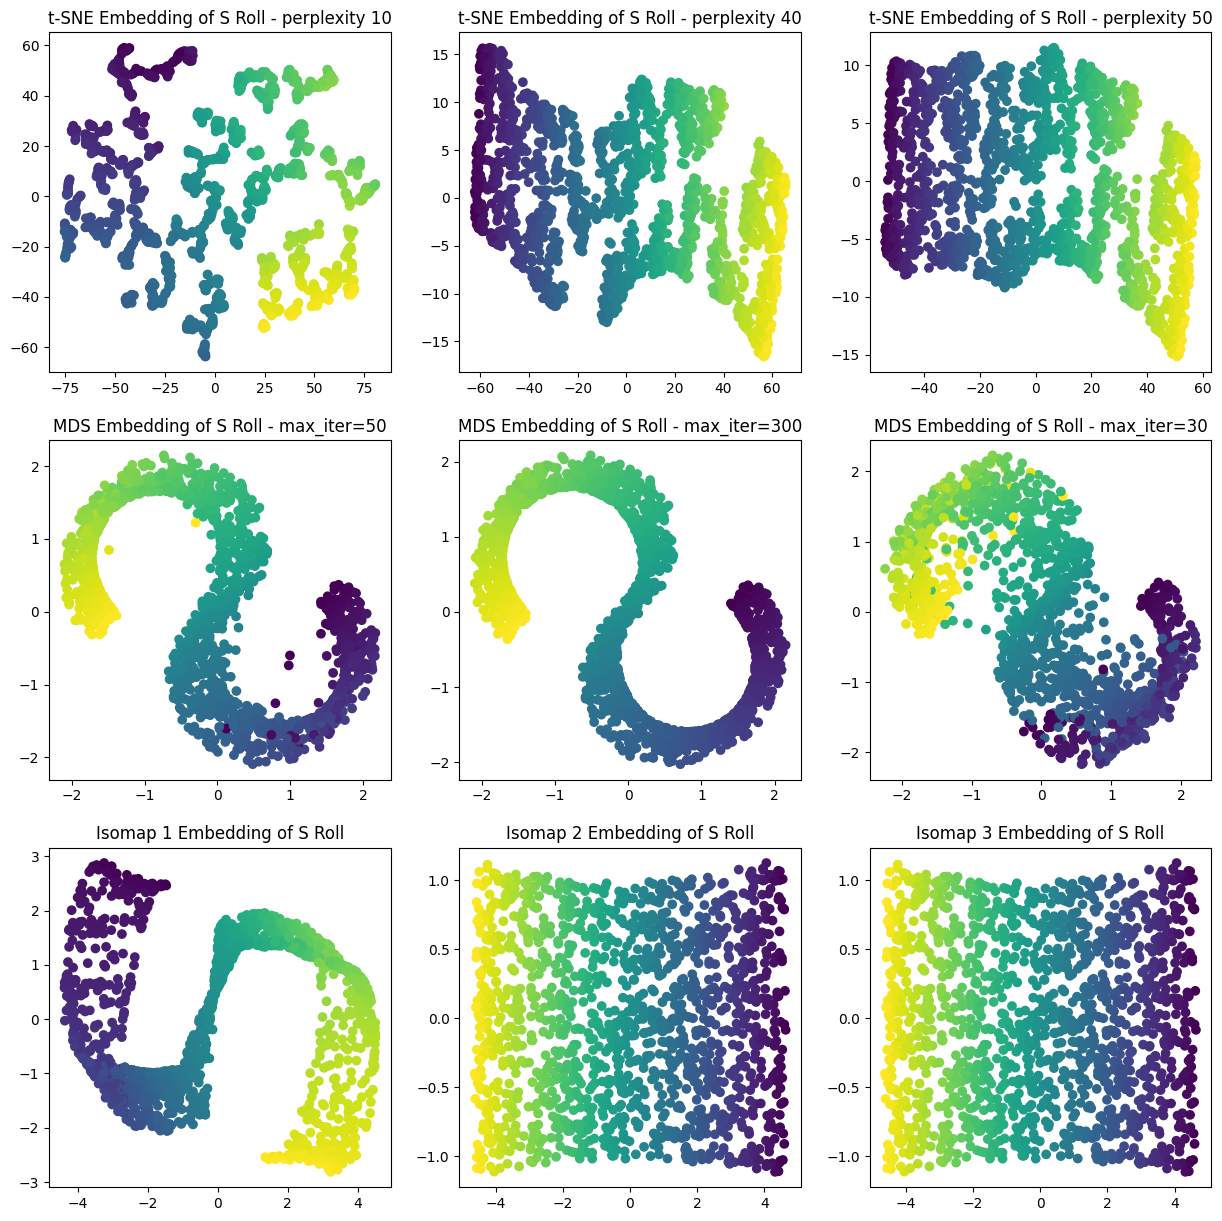

In [181]:
## Plot
fig, axs = plt.subplots(3,3, figsize=(15, 15))
axs[0,0].scatter(lab_tsne_1[:, 0], lab_tsne_1[:, 1], c=S_color)
axs[0,1].scatter(lab_tsne_2[:, 0], lab_tsne_2[:, 1], c=S_color)
axs[0,2].scatter(lab_tsne_3[:, 0], lab_tsne_3[:, 1], c=S_color)
axs[0,0].set_title("t-SNE Embedding of S Roll - perplexity 10")
axs[0,1].set_title("t-SNE Embedding of S Roll - perplexity 40")
axs[0,2].set_title("t-SNE Embedding of S Roll - perplexity 50")
axs[1,0].scatter(lab_mds_1[:, 0], lab_mds_1[:, 1], c=S_color)
axs[1,1].scatter(lab_mds_2[:, 0], lab_mds_2[:, 1], c=S_color)
axs[1,2].scatter(lab_mds_3[:, 0], lab_mds_3[:, 1], c=S_color)
axs[1,0].set_title("MDS Embedding of S Roll - max_iter=50")
axs[1,1].set_title("MDS Embedding of S Roll - max_iter=300")
axs[1,2].set_title("MDS Embedding of S Roll - max_iter=30")
axs[2,0].scatter(lab_isomap_1[:, 0], lab_isomap_1[:, 1], c=S_color)
axs[2,1].scatter(lab_isomap_2[:, 0], lab_isomap_2[:, 1], c=S_color)
axs[2,2].scatter(lab_isomap_3[:, 0], lab_isomap_3[:, 1], c=S_color)
axs[2,0].set_title("Isomap 1 Embedding of S Roll")
axs[2,1].set_title("Isomap 2 Embedding of S Roll")
axs[2,2].set_title("Isomap 3 Embedding of S Roll")
plt.show()

## Applications

In this section, we present a few applications of dimensionality reduction techniques with real data.

### PCA for visualization: Palmer penguins

We are going to use the [palmerpenguins](https://allisonhorst.github.io/palmerpenguins/) dataset. It contains information about 3 types of Palmer penguins, namely Adelie, Gentoo and Chinstrap:

<img src='https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png' width="500">

Source: Artwork by @allison_horst

Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

Reference: Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. DOI: [10.5281/zenodo.3960218](https://allisonhorst.github.io/palmerpenguins/).

In [ ]:
# Import data
url_penguin = 'https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_10/data/penguins.csv'

df_peng = pd.read_csv(url_penguin).dropna().reset_index()
df_peng.head()

,index,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male


We have 4 numerical features ('bill length', 'bill depth', 'flipper length', and 'body mass'), so visualizing information about our penguins would require to select 2 or 3 features, or instead, to use dimensionality reduction!

Let's check the correlation matrix:

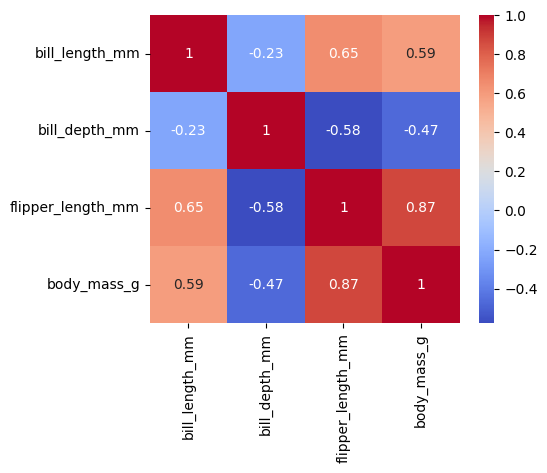

In [ ]:
# Correlation
X_peng = df_peng[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
plt.figure(figsize=(5,4))
sns.heatmap(X_peng.corr(), annot=True, cmap='coolwarm')
plt.show()

There are some high correlations, so PCA may be useful. Note that our features have very different scales. Hence, before applying PCA, each feature should be centered with unit variance. We use the `StandardScaler` module of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)).

In [ ]:
# Standardize data
X_peng_normalized = StandardScaler().fit_transform(X_peng)

We now apply PCA reducing our 4-dimensional space to 2 dimensions:

In [ ]:
# Apply PCA with 2 components
pca_peng = PCA(n_components = 2).fit(X_peng_normalized)
X_peng_pca = pca_peng.transform(X_peng_normalized)

# Visualize in dataframe
df_pca_peng = pd.DataFrame(data = X_peng_pca[:,:2], columns = ['PC 1', 'PC 2'])
df_pca_peng['species'] = df_peng['species']
df_pca_peng['sex'] = df_peng['sex']
df_pca_peng.head()

,PC 1,PC 2,species,sex
0,-1.853593,0.032069,Adelie,male
1,-1.316254,-0.443527,Adelie,female
2,-1.376605,-0.161230,Adelie,female
3,-1.885288,-0.012351,Adelie,female
4,-1.919981,0.817598,Adelie,male


Let's visualize the results:

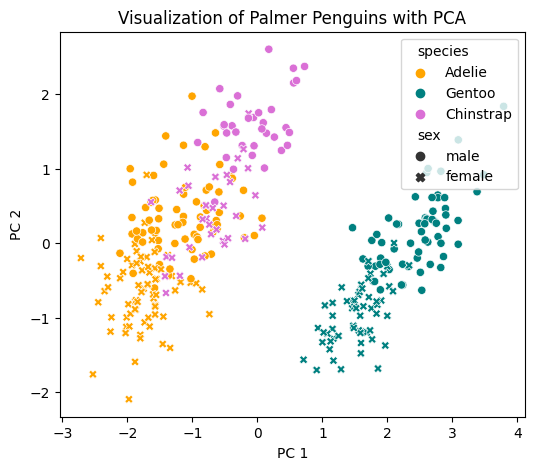

In [ ]:
colors = {'Adelie':'orange', 'Gentoo': 'teal', 'Chinstrap':'orchid'}

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_pca_peng, x="PC 1", y="PC 2",
                    hue="species", palette = colors, style="sex")
plt.title('Visualization of Palmer Penguins with PCA')
plt.show()

We can see a clear separation between Gentoo penguins and the other species. The distinction between male and female is also preserved. The main overlap is between female Chinstrap and male Adelie.

Let's have a look at our eigenvector to check the magnitude of each original feature in the principal components. We'll create a dataframe and also add the percentage of explained variance by each component:

In [ ]:
feature_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
# Principal components
df_pca_peng_components = pd.DataFrame(pca_peng.components_, columns=feature_names, index=['PC 1', 'PC 2'])
df_pca_peng_components['Explained variance [%]'] = pca_peng.explained_variance_ratio_
df_pca_peng_components

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Explained variance [%]
PC 1,0.453753,-0.399047,0.576825,0.549675,0.686339
PC 2,0.600195,0.796170,0.005788,0.076464,0.194529


Our first principal component explains about 69% of the variance, and the second principal component explains about 19%, so 88% overall. Not bad!

Finally, we can visualize the magnitude of each original feature in the principal components with a plot:

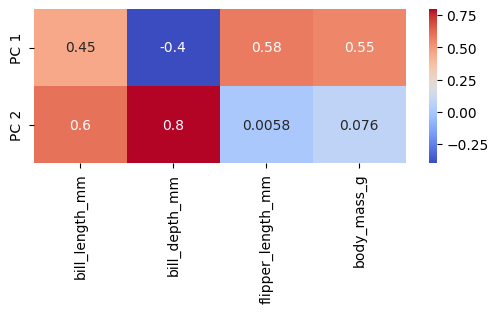

In [ ]:
# Plot feature magnitude
plt.figure(figsize=(6, 2))
sns.heatmap(df_pca_peng_components[feature_names], annot = True, cmap='coolwarm')
plt.show()

### Number Classification: with vs. without PCA

We will try to classify handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The goal it to predict the number that is written based on a pixelised image.

In [ ]:
#load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

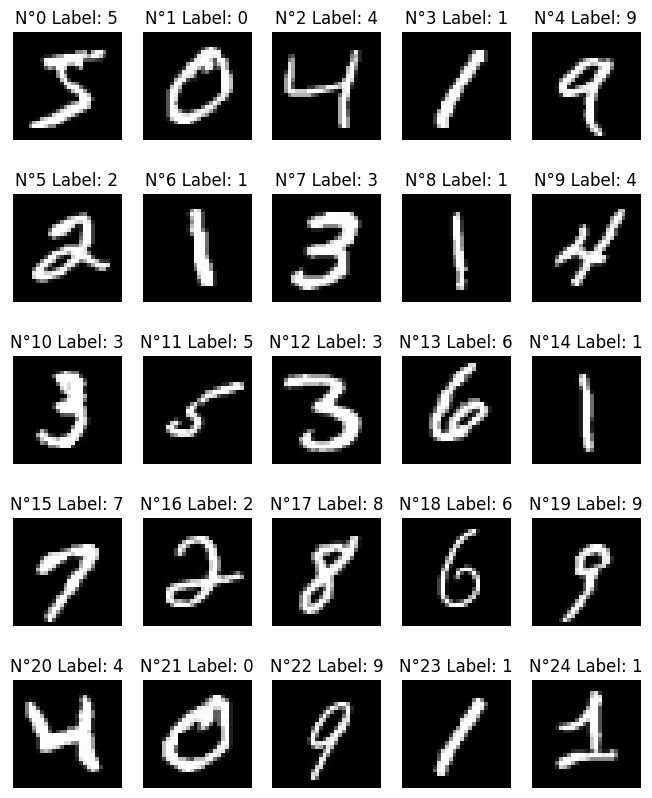

In [ ]:
#visualize the dataset
images_and_labels = list(zip(x_train, y_train))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.6, hspace=.35)
for i, (image, label) in enumerate(images_and_labels[:25]):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    plt.title('N°%i Label: %i' % (i, label))

In [ ]:
#reshape the data
X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [ ]:
#take a smaller sample for computational purposes
size_sample=10000
X_train = X_train[:size_sample]
y_train = y_train[:size_sample]

#calculate the number of clusters
total_clusters = len(np.unique(y_test[:size_sample]))

In [ ]:
#get the informations about the label
def retrieve_info(cluster_labels,y):
  # Initializing
  reference_labels = {}
  # For loop to run through each label of cluster label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def get_labels(cluster_labels, y):
  reference_labels = retrieve_info(cluster_labels,y)
  number_labels = np.random.rand(len(cluster_labels))
  for i in range(len(cluster_labels)):
    number_labels[i] = reference_labels[cluster_labels[i]]
  return number_labels

In [ ]:
#create a function to return the results
def MNIST_classification(tsne=False):
    tsne = TSNE(n_components=2, perplexity=40)
    kmeans = KMeans(n_clusters = total_clusters)
    # Fit model
    start = time.time()
    if tsne:
      X_transformed = tsne.fit_transform(X_train)
    else:
      X_transformed = X_train
    kmeans.fit(X_transformed, y_train)
    end = time.time()

    #labels
    labels=kmeans.labels_
    train_labels = get_labels(labels, y_train)

    # Indicators
    run_time = round(end-start, 4)
    train_accuracy = round(accuracy_score(train_labels, y_train), 4)
    results = [run_time, train_accuracy]
    return results

In [ ]:
#computing and showing the results, this may take a while
results = MNIST_classification()
results_tsne = MNIST_classification(tsne=True)

df_MNIST_results = pd.DataFrame(data=results,
                           index = ['Running time', 'Training accuracy'],
                           columns = ['KMeans, without TSNE:'])
df_MNIST_results['KMeans, with TSNE:'] = results_tsne
df_MNIST_results

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Let's try to visualize the TSNE in action:

In [ ]:
#performing TSNE on a smaller sample
tsne = TSNE(n_components=2)
x_transformed = tsne.fit_transform(X_train[:3000, :])
tsne_df = pd.DataFrame(np.column_stack((x_transformed, y_train[:3000])), columns=['X', 'Y', "Targets"])
tsne_df.loc[:, "Targets"] = tsne_df.Targets.astype(int)

<ipython-input-32-8df384ec7cca>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tsne_df.loc[:, "Targets"] = tsne_df.Targets.astype(int)


<Figure size 1000x800 with 0 Axes>

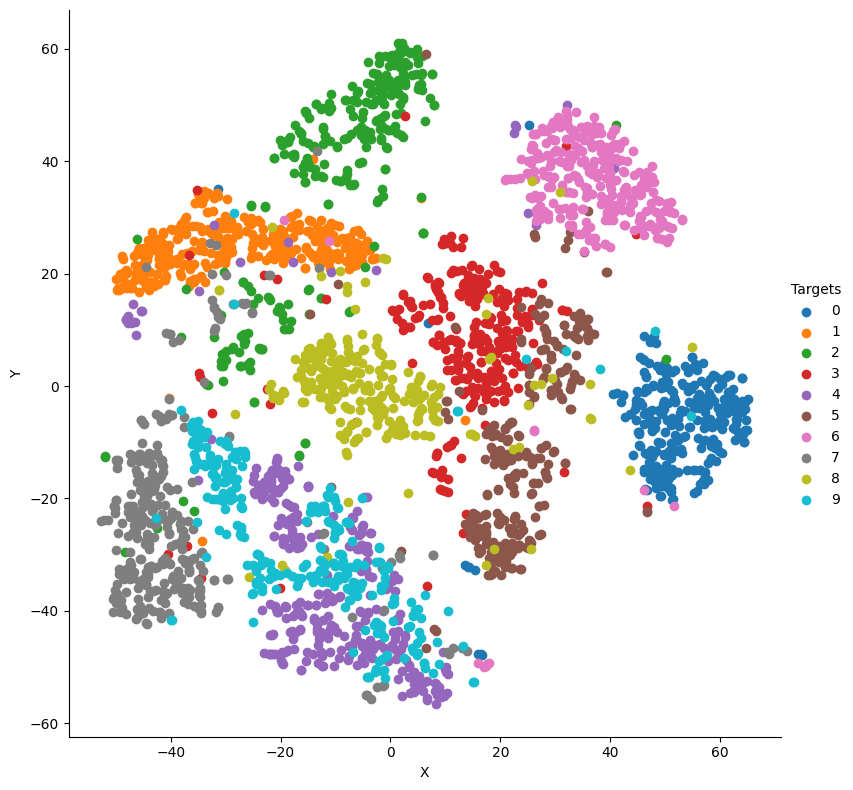

In [ ]:
#visualizing tsne
plt.figure(figsize=(10,8))
g = sns.FacetGrid(data=tsne_df, hue='Targets', height=8)
g.map(plt.scatter, 'X', 'Y').add_legend()
plt.show()

### Your turn!

Based on [this dataset](https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset), try to visualize some clusters by using different methods seen during this lab. Read the kaggle to gather information about the dataset and what you can do with it.

Plot the different results and try to make it as much visualizing as possible. What methods is more efficient for the clusturing?  

In [ ]:
# Import data
url_covtype = 'https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_10/data/covtype.csv'

df_covtype = pd.read_csv(url_covtype).dropna().reset_index()
df_covtype.head()

,index,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,1,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,2,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,3,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,4,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


A possible solution of what could be done can be seen [here](https://www.kaggle.com/code/minc33/visualizing-high-dimensional-clusters/notebook).